## Imports

In [27]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# preprocessing
from spellchecker import SpellChecker
import nltk
from nltk.corpus import stopwords
from string import punctuation
from transformers import AutoTokenizer
from textstat import textstat
from nltk.util import ngrams
from nltk.lm import NgramCounter


plt.style.use("fivethirtyeight")

In [28]:
torch.cuda.is_available()

False

In [29]:
prompts_train = pd.read_csv("../kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv")
prompts_test = pd.read_csv("../kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv")

summaries_train = pd.read_csv("../kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv")
summaries_test = pd.read_csv("../kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv")

sample_submission = pd.read_csv("../kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv")

## Seed everything

In [30]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(42)

## Visualizations

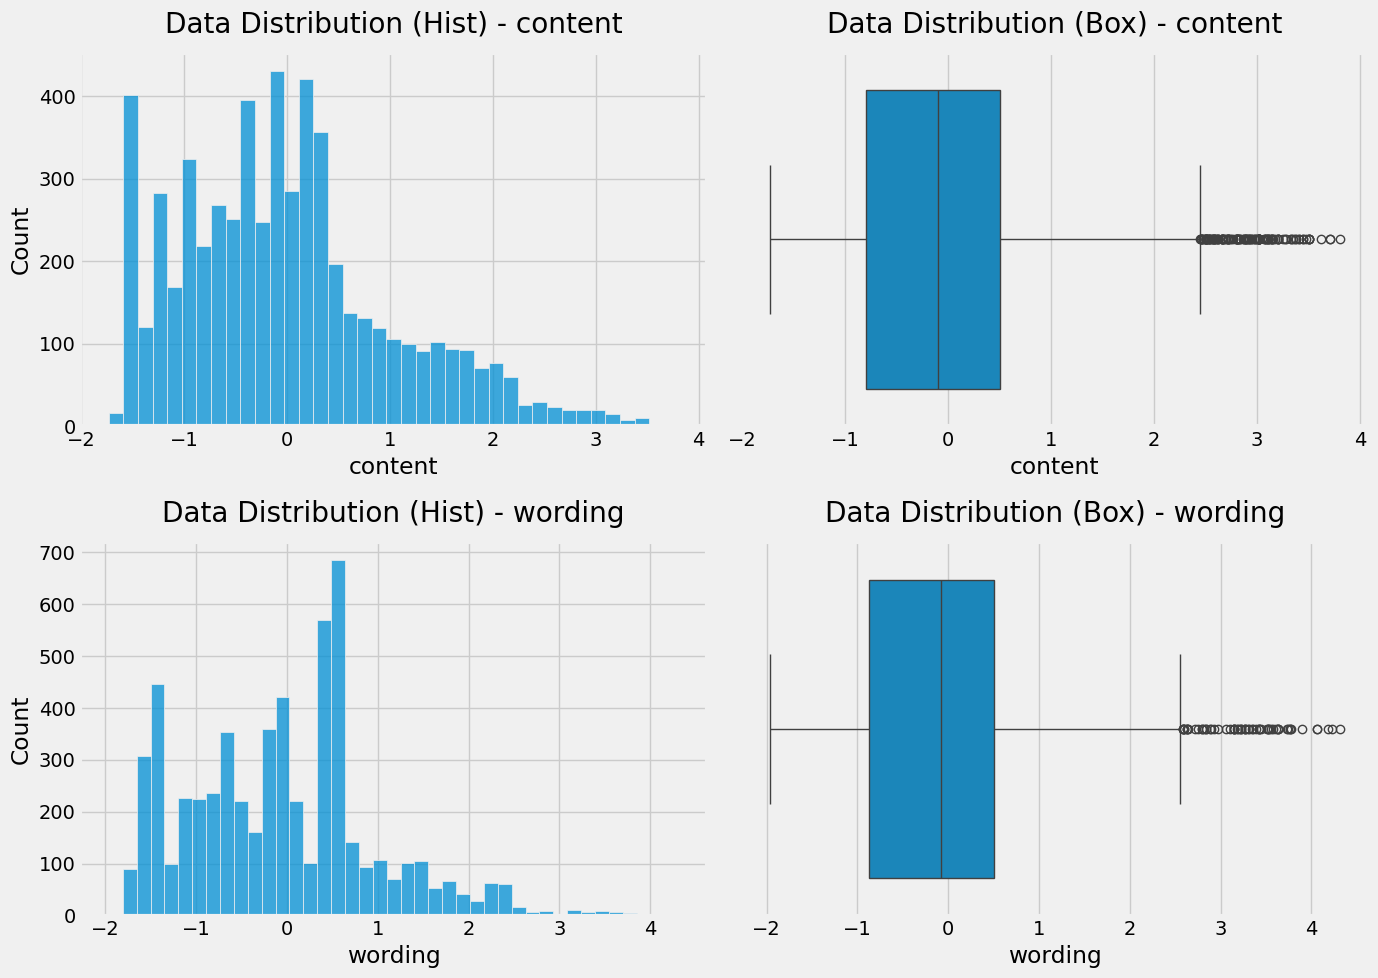

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(x="content", data=summaries_train, ax=ax[0][0])
sns.boxplot(x="content", data=summaries_train, ax=ax[0][1])
sns.histplot(x="wording", data=summaries_train, ax=ax[1][0])
sns.boxplot(x="wording", data=summaries_train, ax=ax[1][1])
ax[0][0].set_title(f"Data Distribution (Hist) - content", pad=15)
ax[0][1].set_title(f"Data Distribution (Box) - content", pad=15)
ax[1][0].set_title(f"Data Distribution (Hist) - wording", pad=15)
ax[1][1].set_title(f"Data Distribution (Box) - wording", pad=15)
fig.tight_layout()

## Data Preparation and Cleaning

In [32]:
summaries_train.shape, prompts_train.shape

((5732, 5), (4, 4))

In [33]:
summaries_train.head(5)

,student_id,prompt_id,text,content,wording
0,8a31b8cc1996,3b9047,In the social pyramid of ancient Egypt the pha...,-0.077267,0.424365
1,8c9411cfc953,39c16e,Aristotle claims that an ideal tragedy should ...,0.559070,-0.634924
2,4387107feb4d,3b9047,The ancient Egyptian system of government was ...,1.376083,2.389443
3,d720eb53c270,ebad26,They put pickle in them to mask the smell of r...,0.297031,-0.168734
4,e887883b946c,ebad26,"""whenever meat was so spoiled that it could no...",-0.093814,0.503833


In [34]:
prompts_train.head(4)

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [35]:
summaries_train["text"][0]

'In the social pyramid of ancient Egypt the pharaoh and those associated with working with vizier were scribes who helped in keeping government records, and slaves who were involved in building such structures as pyramids :D craftmans made and sold jewelry,tools,pottery and other things, slaves and farmers were at the bottom of the pyramid but farmers could make their way up in the social class while slaves would stay the same.'

<Axes: title={'center': 'Prompt ID Distribution'}, ylabel='prompt_id'>

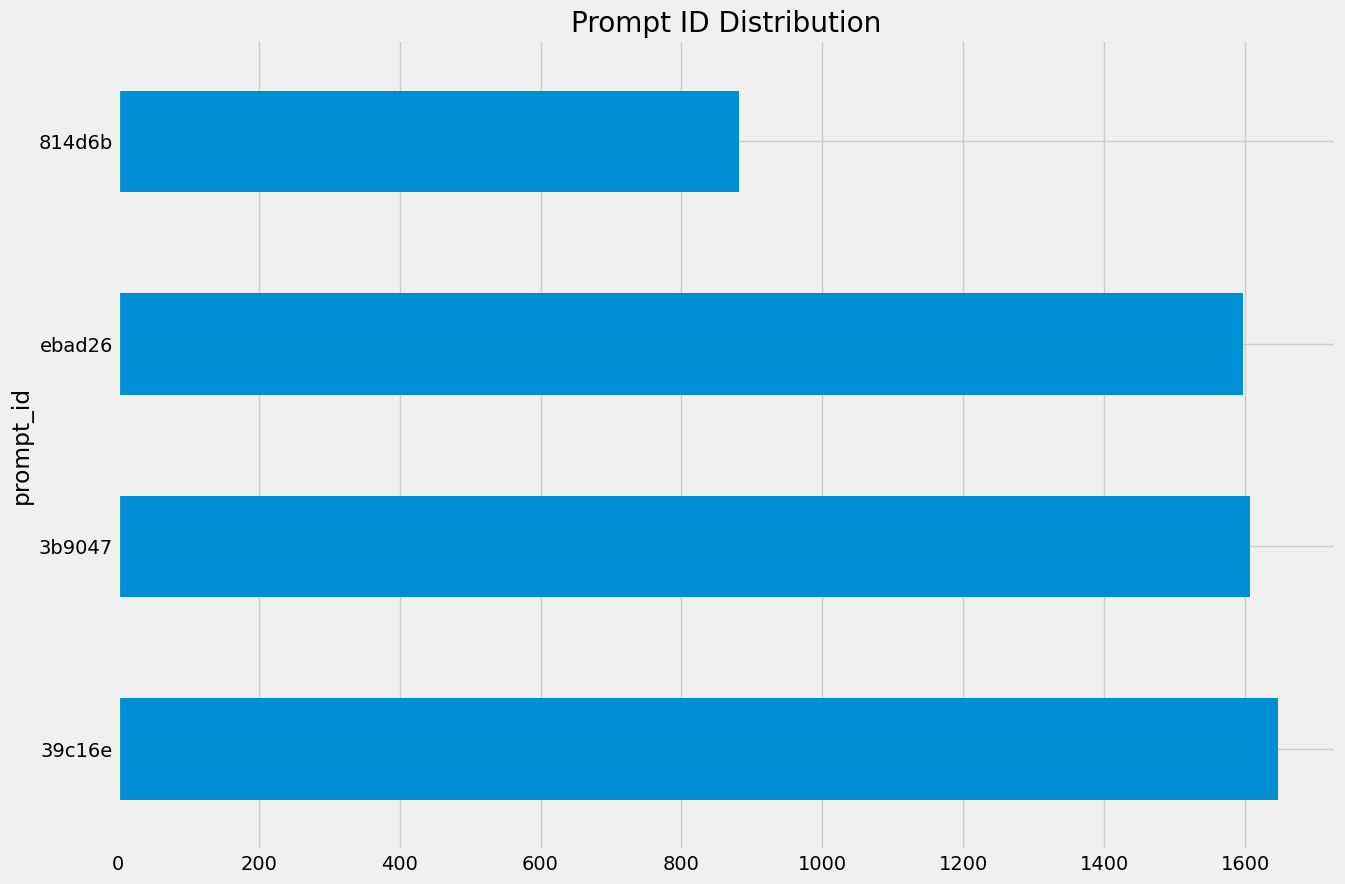

In [36]:
summaries_train["prompt_id"].value_counts().plot.barh(
    figsize=(14, 10), title="Prompt ID Distribution"
)

In [37]:
train_data, test_data = train_test_split(
    summaries_train,
    test_size=0.2,
    random_state=42,
    stratify=summaries_train["prompt_id"],
)

In [38]:
train_data["prompt_id"].value_counts()

prompt_id
39c16e    1317
3b9047    1285
ebad26    1277
814d6b     706
Name: count, dtype: int64

In [39]:
test_data["prompt_id"].value_counts()

prompt_id
39c16e    329
3b9047    322
ebad26    320
814d6b    176
Name: count, dtype: int64

In [40]:
# train_data.to_csv("data/train_data.csv", index=False)
# test_data.to_csv("data/test_data.csv", index=False)

## Word Embeddings

In [41]:
from flair.embeddings import WordEmbeddings

glove_embedding = WordEmbeddings("glove")

In [42]:
glove_embedding

WordEmbeddings(
  'glove'
  (embedding): Embedding(400001, 100)
)

## Text preprocessing

### Merge Prompts and Summaries

In [43]:
merged_train = summaries_train.merge(prompts_train, on="prompt_id", how="inner")

In [44]:
merged_train

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,8a31b8cc1996,3b9047,In the social pyramid of ancient Egypt the pha...,-0.077267,0.424365,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
1,4387107feb4d,3b9047,The ancient Egyptian system of government was ...,1.376083,2.389443,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,3b784d0a5c8f,3b9047,Nobles were the only ont that could hold gover...,0.467722,-0.085653,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
3,1b2ff4d4edd9,3b9047,They were many different social classes. The p...,-0.012957,-0.409480,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
4,108049c01946,3b9047,The ancient Egyptian system of goverment is in...,2.204640,-0.645344,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
...,...,...,...,...,...,...,...,...
5727,d8ae24010bf9,814d6b,The Third Wave experiment was a huge success i...,3.005642,3.226292,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
5728,e32a76187192,814d6b,The Third Wave developed over such a short tim...,0.997243,1.880386,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
5729,2c6d06ca1eea,814d6b,The experiment developed over such a short per...,-0.693773,-0.490571,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
5730,47d4807beb66,814d6b,It was easy for the students to follow this be...,-0.093814,0.503833,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


### Lowercasing / Tokenization / Stopwords / Punctuation

In [45]:
stopwords_list = set(stopwords.words("english"))
punctuation = list(punctuation)

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [46]:
def word_overlap_count(self, row):
    """intersection(prompt_text, text)"""

    def check_is_stop_word(word):
        return word in stopwords_list

    prompt_words = row["prompt_tokens"]
    summary_words = row["summary_tokens"]

    if stopwords_list:
        prompt_words = list(filter(check_is_stop_word, prompt_words))
        summary_words = list(filter(check_is_stop_word, summary_words))
    return len(set(prompt_words).intersection(set(summary_words)))

In [47]:
def clean_text(text):
    text = text.lower()
    text = tokenizer.tokenize(text, truncation=True, padding=True, max_length=1024)
    text = [word for word in text if word not in stopwords_list]
    text = [word for word in text if word not in punctuation]
    text = " ".join(text)
    return text


merged_train["clean_text"] = merged_train["text"].apply(clean_text)
merged_train["clean_prompt_text"] = merged_train["prompt_text"].apply(clean_text)

merged_train["summary_length"] = merged_train["text"].apply(
    lambda x: len(tokenizer.tokenize(x, truncation=True, padding=True, max_length=1024))
)

merged_train["summary_tokens"] = merged_train["text"].apply(
    lambda x: tokenizer.tokenize(x, truncation=True, padding=True, max_length=1024)
)

merged_train["prompt_length"] = merged_train["prompt_text"].apply(
    lambda x: len(tokenizer.tokenize(x, truncation=True, padding=True, max_length=1024))
)

merged_train["prompt_tokens"] = merged_train["prompt_text"].apply(
    lambda x: tokenizer.tokenize(x, truncation=True, padding=True, max_length=1024)
)

In [48]:
merged_train

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,clean_text,clean_prompt_text,summary_length,summary_tokens,prompt_length,prompt_tokens
0,8a31b8cc1996,3b9047,In the social pyramid of ancient Egypt the pha...,-0.077267,0.424365,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,social pyramid ancient egypt pharaoh associate...,egyptian society structured like pyramid top g...,83,"[in, the, social, pyramid, of, ancient, egypt,...",657,"[egyptian, society, was, structured, like, a, ..."
1,4387107feb4d,3b9047,The ancient Egyptian system of government was ...,1.376083,2.389443,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,ancient egyptian system government shaped like...,egyptian society structured like pyramid top g...,157,"[the, ancient, egyptian, system, of, governmen...",657,"[egyptian, society, was, structured, like, a, ..."
2,3b784d0a5c8f,3b9047,Nobles were the only ont that could hold gover...,0.467722,-0.085653,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,nobles ##t could hold gov ##er ##ment posts ph...,egyptian society structured like pyramid top g...,107,"[nobles, were, the, only, on, ##t, that, could...",657,"[egyptian, society, was, structured, like, a, ..."
3,1b2ff4d4edd9,3b9047,They were many different social classes. The p...,-0.012957,-0.409480,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,many different social classes pharaoh ##s e ##...,egyptian society structured like pyramid top g...,75,"[they, were, many, different, social, classes,...",657,"[egyptian, society, was, structured, like, a, ..."
4,108049c01946,3b9047,The ancient Egyptian system of goverment is in...,2.204640,-0.645344,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,ancient egyptian system gov ##er ##ment involv...,egyptian society structured like pyramid top g...,191,"[the, ancient, egyptian, system, of, gov, ##er...",657,"[egyptian, society, was, structured, like, a, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5727,d8ae24010bf9,814d6b,The Third Wave experiment was a huge success i...,3.005642,3.226292,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,third wave experiment huge success showing you...,background third wave experiment took place cu...,253,"[the, third, wave, experiment, was, a, huge, s...",671,"[background, the, third, wave, experiment, too..."
5728,e32a76187192,814d6b,The Third Wave developed over such a short tim...,0.997243,1.880386,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,third wave developed short time period student...,background third wave experiment took place cu...,100,"[the, third, wave, developed, over, such, a, s...",671,"[background, the, third, wave, experiment, too..."
5729,2c6d06ca1eea,814d6b,The experiment developed over such a short per...,-0.693773,-0.490571,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,experiment developed short period time ideals ...,background third wave experiment took place cu...,79,"[the, experiment, developed, over, such, a, sh...",671,"[background, the, third, wave, experiment, too..."
5730,47d4807beb66,814d6b,It was easy for the students to follow this be...,-0.093814,0.503833,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,easy students follow wanted part crowd told so...,background third wave experiment took place cu...,68,"[it, was, easy, for, the, students, to, fo

## Feature Engineering

In [49]:
def extract_ngrams(data, num):
    n_grams = ngrams(nltk.word_tokenize(data), num)
    ngram_list = list(n_grams)
    return len(ngram_list)

In [50]:
# Add flesch reading ease for every text

# Score	Difficulty
# 90-100	Very Easy
# 80-89	Easy
# 70-79	Fairly Easy
# 60-69	Standard
# 50-59	Fairly Difficult
# 30-49	Difficult
# 0-29	Very Confusing

merged_train["flesch_reading_ease"] = merged_train["text"].apply(
    textstat.flesch_reading_ease
)
merged_train["difficult_words"] = merged_train["text"].apply(textstat.difficult_words)
merged_train["text_standard"] = merged_train["text"].apply(textstat.text_standard)
merged_train["comma_count"] = merged_train["text"].apply(lambda x: x.count(","))
merged_train["period_count"] = merged_train["text"].apply(lambda x: x.count("."))
merged_train["bigrams"] = merged_train["clean_text"].apply(extract_ngrams, args=(2,))
merged_train["trigrams"] = merged_train["clean_text"].apply(extract_ngrams, args=(3,))

In [51]:
merged_train

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,clean_text,clean_prompt_text,...,summary_tokens,prompt_length,prompt_tokens,flesch_reading_ease,difficult_words,text_standard,comma_count,period_count,bigrams,trigrams
0,8a31b8cc1996,3b9047,In the social pyramid of ancient Egypt the pha...,-0.077267,0.424365,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,social pyramid ancient egypt pharaoh associate...,egyptian society structured like pyramid top g...,...,"[in, the, social, pyramid, of, ancient, egypt,...",657,"[egyptian, society, was, structured, like, a, ...",16.33,13,12th and 13th grade,4,1,49,48
1,4387107feb4d,3b9047,The ancient Egyptian system of government was ...,1.376083,2.389443,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,ancient egyptian system government shaped like...,egyptian society structured like pyramid top g...,...,"[the, ancient, egyptian, system, of, governmen...",657,"[egyptian, society, was, structured, like, a, ...",73.27,18,6th and 7th grade,5,9,83,82
2,3b784d0a5c8f,3b9047,Nobles were the only ont that could hold gover...,0.467722,-0.085653,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,nobles ##t could hold gov ##er ##ment posts ph...,egyptian society structured like pyramid top g...,...,"[nobles, were, the, only, on, ##t, that, could...",657,"[egyptian, society, was, structured, like, a, ...",74.69,19,6th and 7th grade,10,6,78,77
3,1b2ff4d4edd9,3b9047,They were many different social classes. The p...,-0.012957,-0.409480,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,many different social classes pharaoh ##s e ##...,egyptian society structured like pyramid top g...,...,"[they, were, many, different, social, classes,...",657,"[egyptian, society, was, structured, like, a, ...",52.66,18,7th and 8th grade,6,5,68,67
4,108049c01946,3b9047,The ancient Egyptian system of goverment is in...,2.204640,-0.645344,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,ancient egyptian system gov ##er ##ment involv...,egyptian society structured like pyramid top g...,...,"[the, ancient, egyptian, system, of, gov, ##er...",657,"[egyptian, society, was, structured, like, a, ...",66.07,31,11th and 12th grade,6,7,140,139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5727,d8ae24010bf9,814d6b,The Third Wave experiment was a huge success i...,3.005642,3.226292,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,third wave experiment huge success showing you...,background third wave experiment took place cu...,...,"[the, third, wave, experiment, was, a, huge, s...",671,"[background, the, third, wave, experiment, too...",62.48,44,8th and 9th grade,5,15,122,121
5728,e32a76187192,814d6b,The Third Wave developed over such a short tim...,0.997243,1.880386,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,third wave developed short time period student...,background third wave experiment took place cu...,...,"[the, third, wave, developed, over, such, a, s...",671,"[background, the, third, wave, experiment, too...",70.53,19,7th and 8th grade,1,5,52,51
5729,2c6d06ca1eea,814d6b,The experiment developed over such a short per...,-0.693773,-0.490571,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,experiment developed short period time ideals ...,background third wave experiment took place cu...,...,"[the, experiment, developed, over, such, a, sh...",671,"[background, the, third, 

<Axes: >

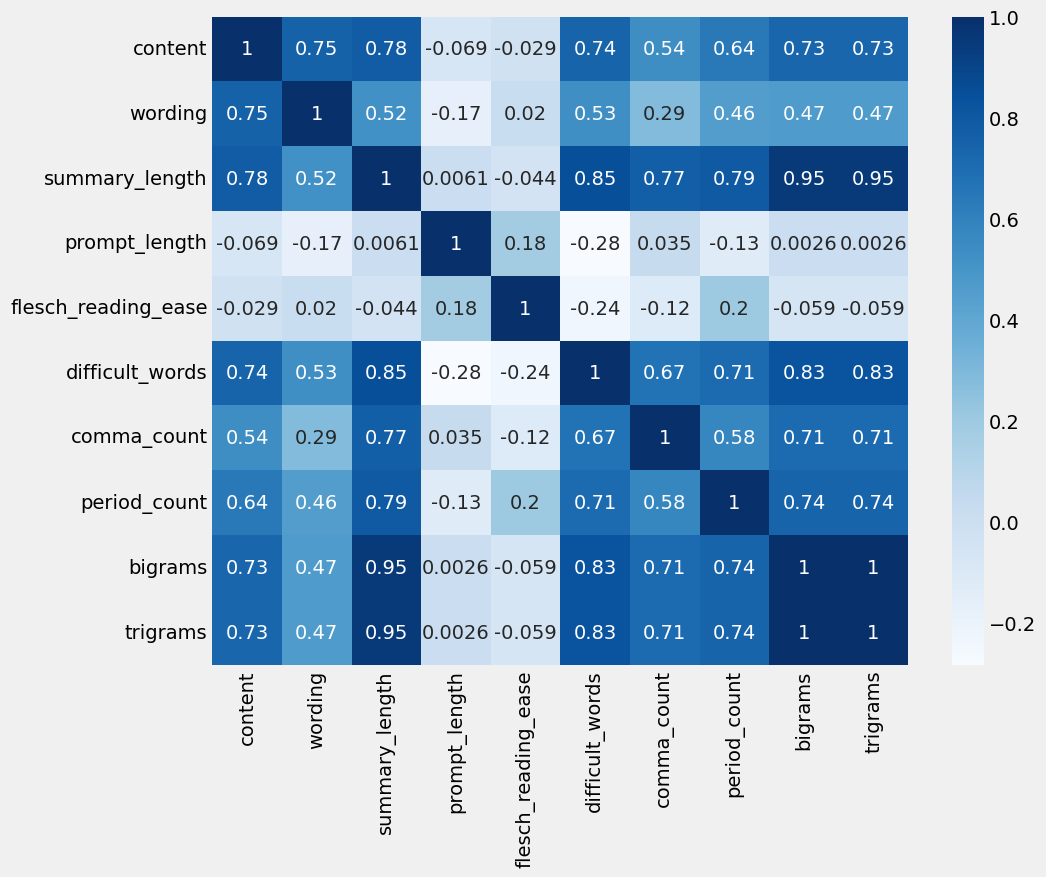

In [53]:
import seaborn as sns
%matplotlib inline


# calculate the correlation matrix on the numeric columns
corr = merged_train.select_dtypes('number').corr()

plt.figure(figsize=(10, 8))

# plot the heatmap
sns.heatmap(corr, cmap="Blues", annot=True)

AttributeError: 'DataFrame' object has no attribute 'to_pandas'

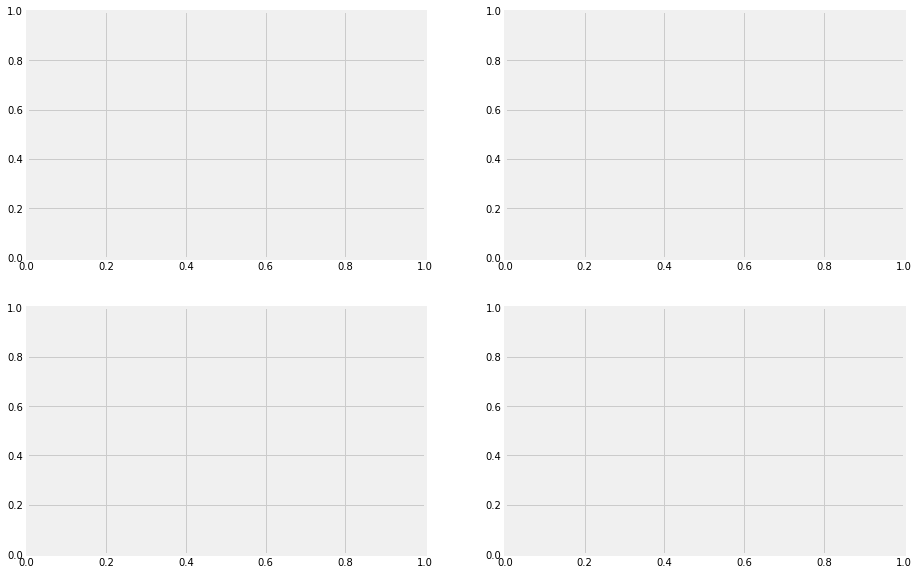

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
sns.scatterplot(x="wording", y="flesch_reading_ease", data=merged_train, ax=ax[0][0])
sns.scatterplot(x="content", y="flesch_reading_ease", data=merged_train, ax=ax[0][1])
fig.tight_layout()

AttributeError: 'DataFrame' object has no attribute 'to_pandas'

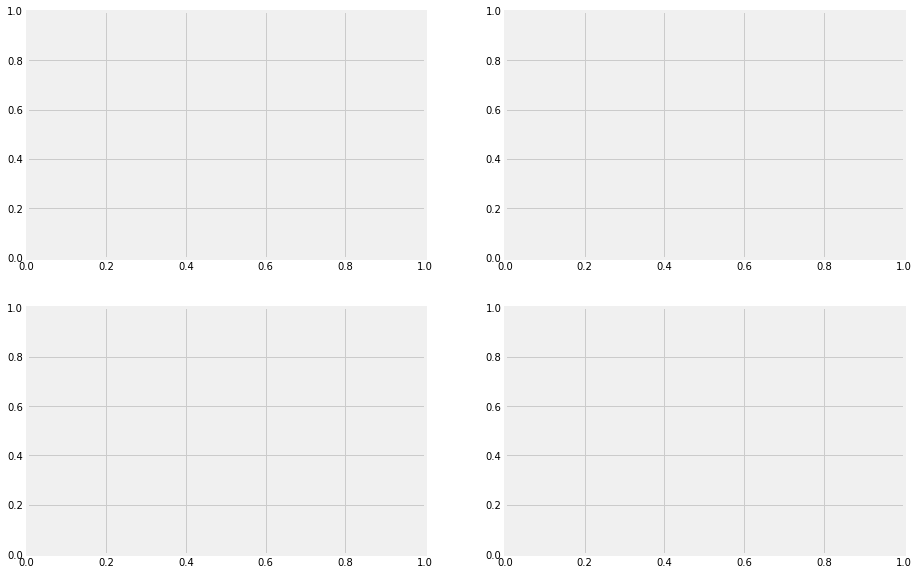

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
sns.scatterplot(x="wording", y="difficult_words", data=merged_train, ax=ax[0][0])
sns.scatterplot(x="content", y="difficult_words", data=merged_train, ax=ax[0][1])
sns.scatterplot(x="wording", y="summary_length", data=merged_train, ax=ax[1][0])
sns.scatterplot(x="content", y="summary_length", data=merged_train, ax=ax[1][1])
fig.tight_layout()

In [ ]:
def plot_corr_matrix(df):
    corr_matrix = df.corr()
    fig, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(corr_matrix, annot=True, ax=ax)
    ax.set_title("Correlation Matrix", pad=15)
    fig.tight_layout()

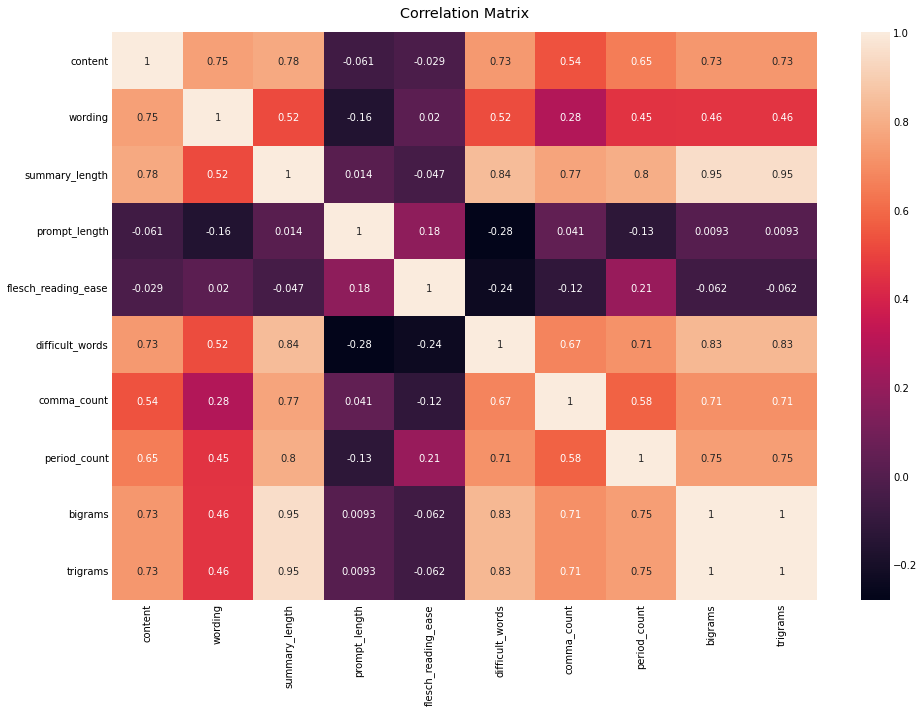

In [ ]:
drop_columns = [
    "student_id",
    "prompt_id",
    "text",
    "prompt_question",
    "prompt_title",
    "prompt_text",
    "prompt_title",
    "clean_text",
    "clean_prompt_text",
    "summary_tokens",
    "prompt_tokens",
    "text_standard",
]
plot_corr_matrix(merged_train.drop(drop_columns, axis=1))